# Identify yourself

Please write your name and uni. Additionally, modify the name of the notebook to include your first and last name.


In [1]:
uni = xs2484
name = Xumin Shen

SyntaxError: invalid syntax (2220820299.py, line 2)

# Hidden Markov Models

First we'll set up some helper functions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(2)

def norm(x): 
    '''
    Return the input normalized to have sum of 1. 
    '''
    return(x/x.sum())

def row_norm(x):
    '''
    Return the input normalized so that each row sums to 1. 
    '''
    return x / x.sum(1, keepdims=True)

## Sampling from the HMM 

An HMM is a `generative process` which means that given parameters T, E and gamma0 we can sample imaginary data from the model. Here's a function to just that, generating a sequence y of length S (as well as the underlying hidden states x). 

In [2]:
def sampleHMM(gamma0, T, E, S):
    '''
Sample from the HMM

Parameters
----------
gamma0
    initial distribution over states of the HMM
T
    transition matrix of size K x K
E
    emission matrix size K x L
S
    sequence length

Returns
-------
x
    Vector of hidden states
y
    Vector of observations
    '''
    K = gamma0.size
    L = E.shape[1]
    x = np.zeros(S, dtype = np.int32)
    y = np.zeros(S, dtype = np.int32)
    x[0] = np.random.choice(K, p=gamma0)
    y[0] = np.random.choice(L, p=E[x[0], :])
    for t in range(1,S):
        x[t] = np.random.choice(K, p = T[x[t-1], :])
        y[t] = np.random.choice(L, p = E[x[t], :])
    return (x,y)

Let's make a toy 2-state HMM and sample from it. 

Text(0.5, 1.0, 'Observations y')

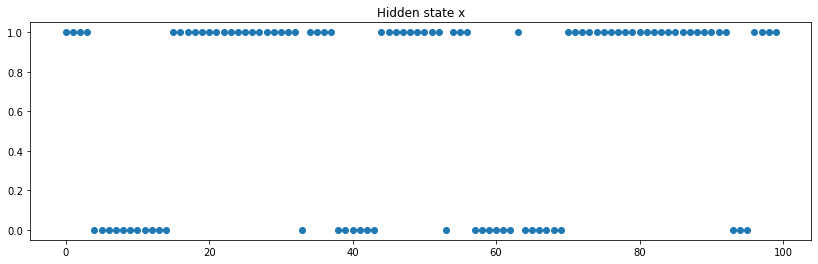

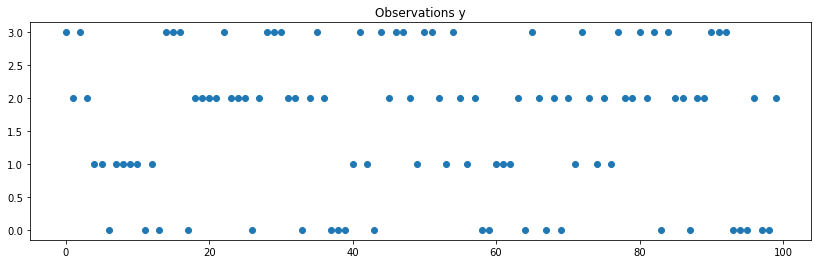

In [3]:
gamma0_true = np.array([0., 1.]) # start in state 1 (rather than 0)
T_true = np.array([[0.8, 0.2], [0.1, 0.9]]) # usually stay in the same state, a "sticky" HMM
E_true = np.array([[0.4, 0.4, 0.1, 0.1], [0.1, 0.1, 0.4, 0.4]]) 

np.random.seed(3)
x,y = sampleHMM(gamma0_true, T_true, E_true, S = 100)

plt.figure(figsize=(14,4))
plt.plot(x, "o")
plt.title("Hidden state x")

plt.figure(figsize=(14,4))
plt.plot(y, "o")
plt.title("Observations y")

Notice that the the Markov chain of hidden states tends to stay in the same state for a while, and that in state 1 we get more 2s and 3s in y. 

## Forwards-backwards

Now let's see what the forward pass might look like. 


First you'll be implementing the forward pass. We first initialize 
$$ f_{1:} = \text{norm}( \gamma_0 \cdot E_{:y_{1}} ) $$ 
where $f = \text{norm}(f_*)$ implies
$$ f_i = \frac{ f^*_i }{ \sum_{i'} f^*_{i'} } $$
Then at each time point $t$
$$ r_{ti} = \sum_j T_{ji} f_{(t-1)j} $$
$$ f^*_{ti} = r_{ti} E_{iy_t} $$
$$ f_{ti} = \frac{ f^*_{ti} }{ \sum_{i'} f^*_{ti'} } $$

### Task [1 point] 

Write the per time point updates above for $r$ and $f$ in matrix notation (this is what you'll want to use in the code). Consider $r$ and $f$ as matrices, use $\cdot$ to denote elementwise multiplication and make use of the `norm` function defined above. 

TODO: replace the ? 
$$ r_{t:} = ?$$
$$ f_{t:} = ?$$

### Task [2 points]

Here's a template for you to fill in. Bear in mind for the time indexing Python uses 0-indexing though whereas in mathematical equations we  always use 1-indexing.   

In [4]:
def forwards(y, gamma0, T, E):
    '''
    
Forward pass of forwards-backwards algorithm. 

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L
Returns
-------
f
    forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''
    S = y.size
    K = T.shape[0]
    # TODO initialize f
    f= np.zeros((S,K))
    # TODO: calculate f[0,:]
    f[0,:] = norm(gamma0*E[:,0])
    # TODO: loop forwared to calculate f[1:,:]
    for t in range(1,S):
        r = T.T@f[t-1,:]
        f[t,:] = r*E[:,y[t]]/np.sum(r*E[:,y[t]])
    return f

Your next task is implementing the equivalent backwards pass. The updates in matrix notation, for $t=\{S-1,\cdots,1\}$ are: 
$$ q_{t:} = (E_{:y_{t+1}})' \cdot b_{t+1:} $$
$$ b_{t:} = (T q'_{t:})' $$ (by convention no `norm` is used). 
Note $b_{S:} = [1, ..., 1]$, $\cdot$ implies elementwise multiplication and $q'$ denotes the transpose. 

### Task [1 point]

Write the updates in NON matrix notation (as I have for the forward pass above): 
$$ q_{ti} = ? $$
$$ b_{ti} = ? $$

### Task [1 point]

Here's a template for you to fill in. Bear in mind for the time indexing Python uses 0-indexing though whereas in mathematical equations we  always use 1-indexing.   

In [5]:
def backwards(y, T, E):
    '''
Backwards pass of forwards-backwards algorithm. 

Parameters
----------
y
    vector of observations, assumed to be in range(E.shape[1])
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
E
    emission matrix size K x L

Returns
-------
b
    Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    S = y.size
    K = T.shape[0]
    # TODO: initialize b
    b = np.ones((S,K))
    for i in range(S-2,-1,-1):
        q = E[:,y[i+1]].T*b[i+1,:]

        b[i,:] = (T@q.T).T

    # TODO: loop backwards from S-2 to 0
    return b

Armed with the forwards and backwards functions we can now get the posterior over X given the observations we just generated, Y. Here we're cheating: since we generated the data we know what the true parameters gamma0, T and E are so we'll use those in forwards-backwards. 

In [6]:
def forwards_backwards( y, gamma0, T, E ):
    f = forwards(y, gamma0, T, E) # result is S x K
    b = backwards(y, T, E)
    gamma = row_norm( f * b ) # get the posterior gamma[t,k] = P(X[t]=k | y[0:S])
    return gamma, f, b

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
assert( abs(gamma[-1,1] - 0.6397375803142555) < 1e-10  ) 
assert( abs(gamma[-50,1] - 0.9566209571811642) < 1e-10  ) 

 Make sure the assertions pass! If not check your backwards code! (and make sure you didn't change the random seed)
 
 We can then look how well our posterior over X agrees with the true X, since we also have that from the simulation. 

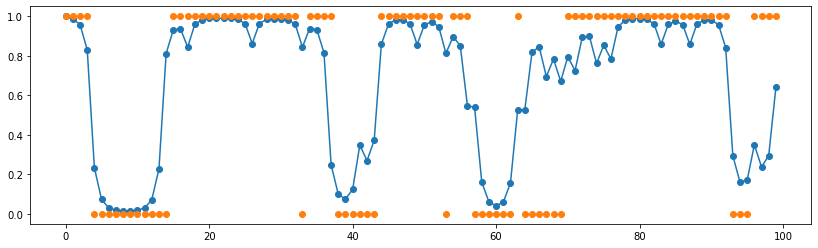

In [7]:
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

You can see that the posterior tends towards the `correct` hidden state, and in fact gets it right 86% of the time:

In [8]:
np.mean((gamma[:,1] > .5) == (x==1))

0.86

There is some uncertainty because either state can generate any four of the observation values, just with somewhat different probabilities. 

## Baum-Welch

Below we provide an implementation of Baum-Welch with the E-step (forwards backwards) and the M-step implemented for T but not for E. 

### Task [2 points]

Implement the M-step for the emission matrix E. From class: 
$$ E^*_{ij} = \sum_{t=1}^S \gamma_{ti} 1[ y_t = j ] $$ 
$$ E_{i:} = \text{norm}(E^*_{i:}) $$

[1 point]: 
Implement the $E$ update without looping over $t$. Hint: making the S x L matrix Y with elements $Y_{tj} = 1[ y_t = j ]$ will be useful. 

In [67]:
def baum_welch(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''  
    K = gamma0.size
    L = 1+max(y)
    S = y.size
    Y = np.zeros([S, L])
    Y[range(S), np.int_(y)] = 1

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b = forwards_backwards(y, gamma0, T, E)
        
        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        T = row_norm(Tstar)
        
        # TODO: E update
        E = (Y.T@gamma).T
        
        E_hat = np.zeros((K,L))
#         for j in range(L):
#             for t in range(S):
                
#                 E_hat[:,j]+=gamma[t,:]*(y[t]==j)
        for i in range(E.shape[0]):
            E[i,:] = norm(E[i,:])

        
        

    return (T, E)

Now we've implemented Baum-Welch let's see how we do recovering the true E and T. 

In [68]:
np.random.seed(2)

T_mle, E_mle = baum_welch(y, gamma0_true)

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

assert( abs(E_mle[0,0] - 0.19228533549712362) < 1e-10 )

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.91 0.09]
 [0.08 0.92]]
Mean absolute error in T: 0.066
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[1.92e-01 3.87e-01 2.20e-01 2.01e-01]
 [2.44e-01 4.46e-13 4.44e-01 3.11e-01]]
Mean absolute error in E: 0.102


Make sure the assertion passes! If not check your update for E. 

These estimates are clearly better than random, but there is some overfitting going on: note in particular the almost 0 probability of generating the 2nd observed value from state 1, which we know should be 0.1. Try a few other random seeds (this will change the random initialization of E and T) to see that most are worse than the one I picked! 

In practice for EM (as well as other optimization approaches that get stuck in local optima) we would do multiple random restarts (e.g. 10 - 50 typically) and somehow score which are best. While we won't cover it here, for HMMs it is possible to calculate the marginal likelihood $P(Y|E,T)$ as part of the forward-backwards algorithm, which can then be used as such as score. 

Let's see how well we did at recovering x: 

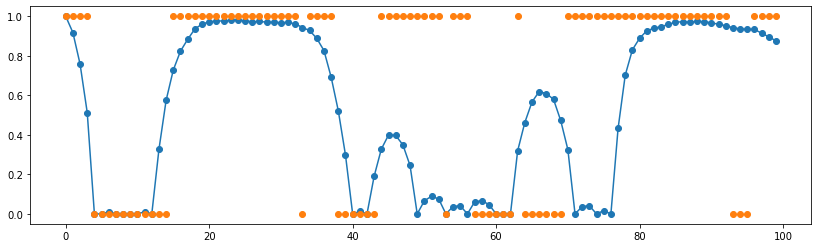

In [69]:
gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle) 
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

The recovered x is "better than random", in that considering this as a classifier, we're getting the right state 69% of the time: 

In [70]:
np.mean((gamma[:,1] > .5) == (x==1))

0.69

However there are many regions where the wrong state is inferred because of the errors in the recovered E matrix. 

One easy solution to this overfitting is to add a pseudocount of 1 to all the values in Estar and Tstar. You can interpret this as putting a Dirichlet(2,...,2) prior on each row of E and T, or using a Dirichlet(1,...,1) prior on those rows but updating to the posterior expectation rather than the maximum likelihood estimate (a bit more like variational Bayes). 

### Task [1 point]

Copy your code for `baum_welch` but add 1 to Estar and Tstar just before normalizing with row_norm. 

In [73]:
def baum_welch_with_pseudocount(y, gamma0, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    y
        vector of observations
    gamma0
        initial distribution of the hidden chain
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j] = P(Y[t]=j | X[t]=i)
  '''  
    K = gamma0.size
    L = 1+max(y)
    S = y.size
    Y = np.zeros([S, L])
    Y[range(S), np.int_(y)] = 1

    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) )
    E = row_norm( np.random.rand(K, L).astype(np.float32) )

    it = 0
    oldT = T
    oldE = E + tol +1

    while (np.abs(oldT-T).sum() + np.abs(oldE-E).sum() > tol) and (it<maxIt):
        it += 1

        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b = forwards_backwards(y, gamma0, T, E)
        
        # M-step
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], E[:,y[t+1]] * b[t+1,:] ) )
        Tstar=Tstar+1
        T = row_norm(Tstar)
        
        # TODO: E update
        E = (Y.T@gamma).T
        
        E_hat = np.zeros((K,L))
#         for j in range(L):
#             for t in range(S):
                
#                 E_hat[:,j]+=gamma[t,:]*(y[t]==j)
        E = E+1
#         for i in range(E.shape[0]):
#             E[i,:] = norm(E[i,:])
        E = row_norm(E)
    return (T, E)

In [74]:
np.random.seed(2)

T_mle, E_mle = baum_welch_with_pseudocount(y, gamma0_true)

assert( abs(E_mle[0,0] - 0.298322068734388) < 1e-10 )

print("True T:\n", T_true)
print("Infered T:\n", T_mle)
print("Mean absolute error in T: %.3f" % np.mean(np.abs(T_true - T_mle)))

print("True E:\n", E_true)
print("Infered E:\n", E_mle )
print("Mean absolute error in E: %.3f" % np.mean(np.abs(E_true - E_mle)))

True T:
 [[0.8 0.2]
 [0.1 0.9]]
Infered T:
 [[0.76 0.24]
 [0.11 0.89]]
Mean absolute error in T: 0.026
True E:
 [[0.4 0.4 0.1 0.1]
 [0.1 0.1 0.4 0.4]]
Infered E:
 [[0.3  0.43 0.16 0.11]
 [0.19 0.07 0.41 0.33]]
Mean absolute error in E: 0.050


Make sure the assertion passes! These estimates are a lot closer to the ground truth than without the pseudocounts. That will result in a better recovery of x too: 

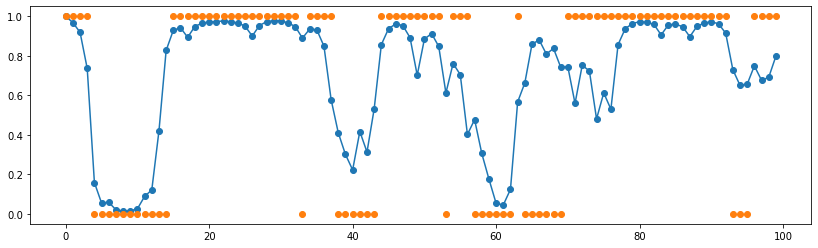

In [75]:
gamma, f, b = forwards_backwards(y, gamma0_true, T_mle, E_mle) 
plt.figure(figsize=(14,4))
plt.plot(gamma[:,1], "-o") # P(X[t] = 1 | Y[0:t])
plt.plot(x, "o")

Now we get the correct state 85% of the time! (Remember with the true E and T we only got 86%!) 

In [76]:
np.mean((gamma[:,1] > .5) == (x==1))

0.85

# Real data: single cell bisulphite sequencing

Now it's time to run on some real data. We'll be looking at the single cell Bisulphite sequencing ("scBS-seq") data from the DeepCpG paper.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import numpy as np 

scBSseq = np.load("scBSseq.npz") # might need to change this

meth_mat = scBSseq["meth_mat"] # positions x cells matrix of counts of methylated CpGs
unmeth_mat = scBSseq["unmeth_mat"] # positions x cells matrix of counts of unmethylated CpGs (i.e. C got converted to T)
positions = scBSseq["positions"] # genomic position of each CpG
chroms = scBSseq["chroms"] # chromomsome of each CpG
cell_names = scBSseq["cell_names"] # cell type and an arbitrary ID
cell_names

array(['2i_1', '2i_10', '2i_11', '2i_12', '2i_2', '2i_3', '2i_4', '2i_5',
       '2i_6', '2i_7', '2i_8', '2i_9', 'MII_1', 'MII_10', 'MII_11',
       'MII_12', 'MII_2', 'MII_3', 'MII_4', 'MII_5', 'MII_6', 'MII_7',
       'MII_8', 'MII_9', 'Ser1', 'Ser10', 'Ser11', 'Ser12', 'Ser13',
       'Ser14', 'Ser15', 'Ser16', 'Ser17', 'Ser18', 'Ser19', 'Ser2',
       'Ser20', 'Ser3', 'Ser4', 'Ser5', 'Ser6', 'Ser7', 'Ser8', 'Ser9'],
      dtype='<U6')

2i_N and SerN are (mouse) embryonic stem cells grown in either "2i" media or serum (from cows!). MII are oocytes which are used as "controls" here since they are easy to handle experimentally and have well defined blocks of methylation. The paper describing this data is [here](https://www-nature-com.ezproxy.cul.columbia.edu/articles/nmeth.3035) if you're interested in more of the technical details. 

## Exploratory data analysis

It's always a good idea to do some exploratory data analysis (EDA) on a new dataset before trying out your fancy new ML model. 

Especially in single-cell data it's important to get a sense how sparse the data is. We filtered this data for CpG positions with reads in at least 10 cells but the data is still pretty sparse:

0.2968330165185542

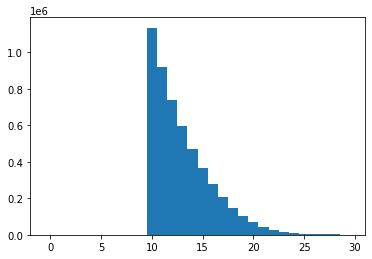

In [78]:
import matplotlib.pyplot as plt

total_counts = meth_mat + unmeth_mat
ncells_with_reads = (total_counts > 0).sum(1)
plt.hist(ncells_with_reads, np.arange(-.5,30.5) )
np.mean(total_counts > 0)

So about 30% of entries have data. 

Principal components analysis (PCA) is an excellent tool for EDA on high dimensional data. It's a little challenging to apply here because there's so much missingness: to handle that we'll add a small pseudocount and only look at CpGs where there is data for at least 25 cells (you can see from the histogram above this is a small proportion!) 

Text(0.5, 0, 'PC')

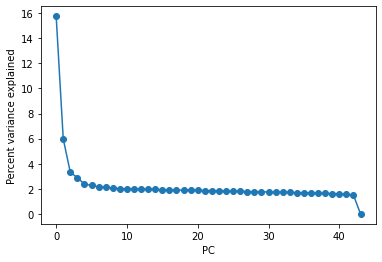

In [80]:
pseudocount = 0.25
meth_level = ( meth_mat + pseudocount) / (total_counts + 2 * pseudocount)
meth_level = meth_level[ncells_with_reads >= 25,:] # only consider CpG positions with reads in 25 (out of 44) cells

meth_level_centered = meth_level - meth_level.mean(1, keepdims=True) # remove the per position mean

# numpy implementation uses too much memory
# u,s,vh = np.linalg.svd(meth_level_centered, full_matrices=True) # use SVD to do PCA (quite cpu/memory intensive)
import torch
torch.manual_seed(0) # torch uses a randomized algorithm so set the seed for reproducibility
usvh = torch.pca_lowrank( torch.tensor(meth_level_centered).to("cpu"), q=44, center=False, niter=10)
u,s,vh = [ g.cpu().numpy() for g in usvh ]
vh = vh.transpose()

plt.plot(100 * s**2 / np.sum(s**2), "o-")
plt.ylabel("Percent variance explained")
plt.xlabel("PC")

The single values here tell us how much variance is represented by each PC. As is common with high dimensional data we see a lot of signal in the first few PCs. 

Plotting the first two PCs we see that cell type drives much of the variation in the data - the cells separate by cell type for the most part. 2i and Ser samples look distinct but more similar to one another than to MII, which is expected given that they are the same cell type just grown in different conditions. 

In [82]:
vh.shape

(44, 44)

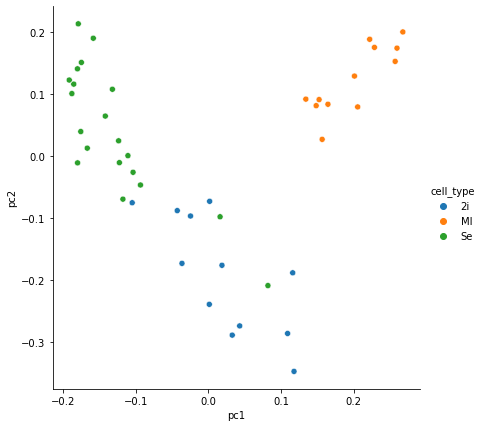

In [81]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    { "pc1" : vh[0,:],
      "pc2" : vh[1,:],
      "cell_type" : [ cn[:2] for cn in cell_names ] } )

_ = sns.pairplot(x_vars = ["pc1"], y_vars = ["pc2"], hue = "cell_type", data = df, height=6 )

## Applying the HMM

PCA isn't a great model for this data for two reasons: 
1. It can't handle missingness (or count based likelihoods) naturally. 
2. It ignores the sequential nature of the data. 

So let's try using an HMM. The data at each CpG position is a vector of methylated and unmethylated counts, which it is natural to model using a binomial likelihood. The emission parameter $E_{ij} \in [0,1]$ is the probability of cell $j$ having a methylated CpG if the hidden state is $i$. 

First we'll rewrite the forwards-backwards algorithm to be agnostic to the form of the likelihood. 

### Task [2 point]

Write new forward backwards updates that take a matrix 
$O_{kt} = P(Y_t | X_t = k) $ instead of Y and E. For the standard HMM 
$O_{kt} = E_{kY_t}$. 

We'll be using longer sequences where the standard implementation of the backwards update can end up being 0 to machine precision. To avoid this, wrap your b[t,:] calculation in a `norm` call (at every $t$ step, not just at the end!). We only care about the values of b[t,:] up to a multiplicative constant so this won't change anything. 

In [9]:
def forwards_generic(gamma0, T, O):
    '''
Forward pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''  
    S = O.shape[1]
    K = T.shape[0]
    # TODO
    
    S = y.size
    K = T.shape[0]
    # TODO initialize f
    f= np.zeros((S,K))
    # TODO: calculate f[0,:]
    f[0,:] = norm(gamma0*E[:,0])
    # TODO: loop forwared to calculate f[1:,:]
    for t in range(1,S):
        r = T.T@f[t-1,:]
        f[t,:] = r*E[:,y[t]]/np.mean(r*E[:,y[t]])

    
    return f

def backwards_generic(T, O):
    '''
Backwards pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    S = O.shape[1]
    K = T.shape[0]
    # TODO
    
    S = y.size
    K = T.shape[0]
    # TODO: initialize b
    b = np.ones((S,K))
    for i in range(S-2,-1,-1):
        q = E[:,y[i+1]].T*b[i+1,:]

        b[i,:] = (T@q.T).T

    # TODO: loop backwards from S-2 to 0
    return b
    
    return b

def forwards_backwards_generic(gamma0, T, O):
    '''
Forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
gamma
    S x K matrix: posterior gamma[t,k] = P(X[t]=k | y[0:S])
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    f = forwards_generic(gamma0, T, O) 
    b = backwards_generic(T, O)
    gamma = row_norm( f * b ) 
    return gamma, f, b


def forwards_backwards_check( y, gamma0, T, E ):
    O = E[:,y] # TODO: calculate O from E and y
    return forwards_backwards_generic(gamma0, T, O)

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
gamma_check, f, b = forwards_backwards_check( y, gamma0_true, T_true, E_true )
assert( abs(gamma[-1,1] - gamma_check[-1,1]) < 1e-10  ) 

NameError: name 'E' is not defined

In [101]:
def forwards_generic(gamma0, T, O):
    '''
Forward pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
  '''  
    S = O.shape[1]
    K = T.shape[0]
    # TODO

    # TODO initialize f
    f= np.zeros((S,K))
    # TODO: calculate f[0,:]
    f[0,:] = norm(gamma0*O[:,0])
    # TODO: loop forwared to calculate f[1:,:]
    for t in range(1,S):
        r = T.T@f[t-1,:]
        f[t,:] = r*O[:,y[t]]/np.mean(r*O[:,y[t]])
    return f


def backwards_generic(T, O):
    '''
Backwards pass of forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    S = O.shape[1]
    K = T.shape[0]
    # TODO
    b = np.ones((S,K))
    for i in range(S-2,-1,-1):
        q = O[:,y[i+1]].T*b[i+1,:]

        b[i,:] = (T@q.T).T
        b = norm(b)
    # TODO: loop backwards from S-2 to 0
    return b

def forwards_backwards_generic(gamma0, T, O):
    '''
Forwards-backwards algorithm. 

Parameters
----------
gamma0
    initial distribution as vector of size K
T
    transition matrix of size K x K
O
    likelihood terms for observations: P(Y_t | X_t = k) K x S

Returns
-------
gamma
    S x K matrix: posterior gamma[t,k] = P(X[t]=k | y[0:S])
f
    S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
b
    S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
  '''
    f = forwards_generic(gamma0, T, O) 
    b = backwards_generic(T, O)
    gamma = row_norm( f * b ) 
    return gamma, f, b

def forwards_backwards_check( y, gamma0, T, E ):
    O = np.zeros((E.shape[0],len(y)))

    for t in range(len(y)):
        for k in range(E.shape[0]):
            O[k,t] = E[k,y[t]] # TODO: calculate O from E and y
        O[:,t] = norm(O[:,t])
    return forwards_backwards_generic(gamma0, T, O)

gamma, f, b = forwards_backwards( y, gamma0_true, T_true, E_true )
gamma_check, f, b = forwards_backwards_check( y, gamma0_true, T_true, E_true )
print(gamma[-1,1])
print(gamma_check[-1,1])
assert( abs(gamma[-1,1] - gamma_check[-1,1]) < 1e-10  ) 

0.6397375803142555
0.9658503265278905


AssertionError: 

Make sure the assertion passes. 

## Binomial HMM

Now we're ready to make a version of forward-backwards for our binomial vectors. We want 
$$ O_{kt} = P(Y_t | X_t = k) = \prod_{n=1}^N P(Y_{tn} | X_t = k) $$ 

The binomial likelihood for an individual cell is 
$$ P(Y_{tn} | X_t = k) = Bin( M_{tn} | M_{tn} + U_{tn}, E_{k n} ) = E_{k n}^{M_{tn}} (1-E_{k n})^{U_{tn}} $$
where $M_{tn}$ and $U_{tn}$ are the methylated and unmethylated counts respectively and $E_{ij} = P(Y_{tj} = 1 | X_t = i )$ is a matrix of binomial probabilities. When multiplying probabilities together it's generally a good idea to work in log probability space, where multiplication corresponds to addition. 

NOTE: a convenient aspect of the binomial likelihood is that $M_{tn} + U_{tn} = 0$ corresponds to entry $tn$ being missing, so we don't have to do anything special to handle "missingness". 

### Task [1 point]

Write $\log O_{kt}$ in terms of $E$, $M$ and $U$: 
$$\log O_{kt} = ? $$

### Task [1 point]

Express this in matrix notation, where assuming the log function is applied elementwise: 
$$\log O = ? $$

### Task [1 point]

Implement your calculation in this function. You should use the `np.log1p` in place of `np.log(1+.)` function where appropriate for better numerical stability! 

In [ ]:
def forwards_backwards_binomial( meth_mat, unmeth_mat, gamma0, T, E ):
    # TODO: calculate logO
    logO -= logO.max(0,keepdims=True) # not strictly necessary but more numerically stable
    O = np.exp(logO)
    
    gamma, f, b = forwards_backwards_generic(gamma0, T, O)
    return gamma, f, b, O

It is often useful for methods with local optima (like EM fitting of an HMM) to use some fast and/or analytic method to get a reasonable initialization. As well as hopefully finding a better optimum than random initialization, this makes the analysis reproducible without setting random seeds. 

One way to that here is using the PCA we've already done. The vh matrix is a PCs x L (cells) weight matrix analogous to the E matrix in our binomial model. We'll take the top K PCs of vh and rescale to get valid probabilities: 

In [ ]:
K = 10

E_init = vh[:K,:]
E_init -= E_init.min(1, keepdims=True)
E_init /= E_init.max(1, keepdims=True)
E_init = 0.8 * E_init + 0.1

For the transition matrix T we expect that the most likely transition is to stay in the same state (since we know neighboring CpGs have correlated methylation) so we'll just set T to have more weight on the diagonal: 

In [ ]:
T_init = row_norm(np.identity(K) + 1/K)

Now we can test our new forward-backwards algorithm on some of the "real" data. To keep things fast we'll just try this out on the first 30000 CpGs. 

In [ ]:
S = 30000 # np.sum(chroms=='1') # just run on chromosome 1

gamma0 = np.full(K,1/K)
gamma, f, b, O = forwards_backwards_binomial( meth_mat[:S,:], unmeth_mat[:S,:], gamma0, T_init, E_init )

assert( abs(gamma[-1,4] - 1.0168727093165696e-06) < 1e-10  ) 

Make sure this assertion passes! 

## Baum-Welch for the binomial HMM

Now let's implement Baum-Welch so we can find good parameters E and T for the binomial HMM applied to the methylation data. 

### Task [2 points]

Derive the M-update for the emission matrix E. Students have struggled with this question in the past so I'm putting a lot more exposition here. 

In the M step we try to optimize the expected log likelihood wrt whatever parameter (in this case E). So first you should figure out what the log likelihood is. The likelihood for an individual position and cell if we know $X_t=k$ is 
$$P(Y_{tn} | X_t = k) = Bin( M_{tn} | M_{tn} + U_{tn}, E_{k n} ) = E_{k n}^{M_{tn}} (1-E_{k n})^{U_{tn}} $$
However, we don't know what state $X_t$ will be in so we can use the trick we used for the regular discrete likelihood HMM in class: 
$$ P(Y_{tn} | X_t) = \prod_k P(Y_{tn} | X_t = k)^{1[X_t = k]}$$
where $1[.]$ is the indicator function and importantly $ \mathbb{E}_Q( 1[X_t = k]) = \gamma_{kt}$ where $\gamma$ comes from forward backwards. 

The complete likelihood is just 
$$ P(Y | X ) = \prod_{tn} P(Y_{tn} | X_t) $$

So you need to 
- Take the log of $P(Y | X )$.
- substitute in the expression for $P(Y_{tn} | X_t)$
- substitute in the expression for $P(Y_{tn} | X_t = k)$
- take the expectation wrt $Q$ from forwards backwards (so you'll have $\gamma$ terms) 
- maximize the resulting expression wrt to $ E_{kl} $. There are two ways to do this: 1) differentiate wrt to $ E_{kl} $, set that expression =0 and solve OR 2) look up the binomial likelihood (e.g. on wikipedia) and match to the function form you have, then you can get the optimal E just from looking up what the maximum likelihood estimator for the binomial is. 

Finally you need to add the Beta(2,2) prior: you'll notice that the log pdf $ (2-1) \log E + (2-1) \log (1-E) $ has the same functional form as your final expression (this is due to beta being the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the binomial) so it's easy to incorporate.

You should be able to do this using matrix multiplication rather than a loop. Include a pseudocount of 1 (corresponding to a Beta(2,2) prior on elements of E). 

YOUR DERIVATION HERE

### Task [2 points] 

Implement the M-update you just derived for the emission matrix in the code below: 

In [ ]:
def baum_welch_binomial(meth_mat, unmeth_mat, gamma0, E_init = None, T_init = None, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters
    ----------
    meth_mat
        S x L matrix of methylated counts
    unmeth_mat
        S x L matrix of unmethylated counts
    gamma0
        initial distribution of the hidden chain
    E_init
        Optional initialization of emission matrix E. 
    T_init
        Optional initialization of transition matrix T. 
    tol
        tolerance for the stopping criterion
    maxIt
        maximal number of iterations

    Returns
    -------
    T
        K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E
        K x L estimate of the emission matrix E[i,j], the binomial probability of methylation in cell j, given X[t]=i. 
  '''  
    K = gamma0.size
    L = meth_mat.shape[1]
    S = meth_mat.shape[0]
    
    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) ) if (T_init is None) else T_init
    E = 0.1 + 0.8 * np.random.rand(K,L) if (E_init is None) else E_init # don't put values too close to 0 or 1

    it = 0

    param_change = np.inf
    
    while (param_change > tol) and (it<maxIt):
        it += 1
        print("Iteration: %i Param change: %.3g" % (it, param_change))
        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b, O = forwards_backwards_binomial(meth_mat, unmeth_mat, gamma0, T, E )
        assert(not np.any(np.isnan(gamma)))

        # M-step 
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], O[:,t+1] * b[t+1,:] ) )
        T = row_norm(Tstar)

        # TODO: M-step update for E

        assert(not np.any(np.isnan(E)))
        
        #param_change = np.abs(oldT-T).sum() + np.abs(oldE-E).sum()
        param_change = max( np.abs(oldT-T).max() , np.abs(oldE-E).max() )

    return (T, E, gamma)

Alright, let's run it! We'll train on the first 30000 positions. 

Because this is "real" data we can't check whether our estimates of T and E against against ground truth. One approach to assessing our model and parameters is prediction of held out data, just like we would for a supervised model. In this case we'll "hold out" the counts for entries with coverage > 1  (about 13% of entries) and if we can impute them. 

In [ ]:
test_meth = meth_mat[:S, :]
test_unmeth = unmeth_mat[:S, :]
test_total = test_meth + test_unmeth
to_mask = test_total >= 2 # often you would use a random set of entries
print(to_mask.mean()) # how many entries are we testing on? 
test_meth_masked = test_meth.copy() 
test_meth_masked[to_mask] = 0
test_unmeth_masked = test_unmeth.copy() 
test_unmeth_masked[to_mask] = 0

T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked, gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )

You'll notice that the parameters initially change quite a bit then convergence slows down. This is expected behavior for coordinate descent(/ascent), the class of methods that includes EM. For a graphical explanation
![coordinateascent](https://upload.wikimedia.org/wikipedia/commons/e/e3/Coordinate_descent.svg)

And bear in mind the issue is worse in higher dimensions. To cope with this we've set the tolerance pretty loose: in practice additional iterations beyond this often won't gain us anything in terms of predictive accuracy, and might even be detrimental if they result in overfitting (cf. early stopping). 


Let's take a look at the learnt transition matrix T: 


In [ ]:
plt.imshow(T,vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("Hidden state")
plt.xlabel("x[t+1]")
_ = plt.ylabel("x[t]")

Mostly here the HMM stays in the same state, but various other transitions  have substantial mass too. 

We can also look at the emission matrix, which shows clear patterns of states that correspond to methylation shared across cells of a specific type. 

In [ ]:
plt.figure(figsize=(18,8))
plt.imshow(E, vmin=0, vmax=1)
_ = plt.xticks(np.arange(len(cell_names)), cell_names, rotation="vertical")
plt.colorbar()
plt.xlabel("Cell name")
_ = plt.ylabel("Hidden state")

Now we want to calculate $ P(Y_\text{missing} | Y_\text{observed}, E, T) $. We will do this by summing over the posterior gamma_test. 

### Task [1 point] 

Derive $ Z_{tj} = P(Y^\text{missing}_{t} =j | Y_\text{observed}, E, T) $ in terms of $E_{ij} = P(Y_{tj} = 1 | X_t = i )$ and $ \gamma_{ti} = P( X_t = i | Y_\text{observed} )$ by using basic probability rules. You can do this with a single matrix multiply! 

$$ Z_{tj} = ? $$
$$ Z = ? $$

### Task [1 point]

Implement your expression:

In [ ]:
# TODO: calculate Z as the expected Y given the posterior over X. Should be S x L
Z = ?
Y_obs = test_meth / test_total
correct_pred = (Y_obs[to_mask]>.5) == (Z[to_mask]>.5)
correct_pred.mean()



This should be 0.88, pretty good considering how sparse the data is. 

Let's visualize some of our predictions: 

In [ ]:
(cpg_start,cpg_end) = (10232143, 10233428)

window = 20000

in_cpg = np.logical_and( chroms == "1" , np.logical_and( cpg_start - window < positions , positions < cpg_end + window ))

meth_mat[in_cpg,:]
unmeth_mat[in_cpg,:]

y = meth_mat[in_cpg,:] / ( unmeth_mat[in_cpg,:] + meth_mat[in_cpg,:] )

plt.figure(figsize=(16,8))
_ = plt.plot( positions[in_cpg], y[:,:12], "o")
_ = plt.plot( positions[in_cpg], Z[in_cpg[:S],:12], "-")

The region with very low methylation is a CpG island. Think through how these lines are created: each position has a distribution over the possible states, and each state corresponds to a vector of binomial probabilities across the cells. 



### Task [3 points]

Vary the number of hidden states from 1 to 10 and see how this impacts imputation accuracy and run time. 

In [ ]:
# implementation here

# RNNs

In deep learning RNNs are often used to handle sequential data. 

## Vanilla RNN

First we'll build a single vanilla "cell", an individual computation unit for the RNN. 

In [ ]:
import torch.nn as nn
import torch 
import torch.nn.functional as F

class MyVanillaRNNCell(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(MyVanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size + hidden_size, hidden_size)
        
    def forward(self, x, h_in):
        """
        Forward computation. 
        
        Parameters
        ----------
        x : torch.tensor
            [batch_size x input_size] input
        h_in : torch.tensor
            [batch_size x hidden_size] hidden state from previous time point
            
        Returns
        -------
        h_out : torch.tensor
            [batch_size x hidden_size] new hidden state 
        """
        combined = torch.cat((x, h_in), 1) # concatenate in feature dimension
        h_out = torch.tanh( self.linear(combined) )
        return h_out



All this does is take the current input (x) and hidden state (h_in) and computes h_out according to $h_{out} = \tanh( W [x, h_in] + b )$. Although we don't see them explicitly in the code, the parameters $W$ and $b$ are stored in the `linear` layer. 

Now we can build an RNN layer as 

In [ ]:
class MyRNNLayer(nn.Module):
    
    def __init__(self, rnn_cell):
        super(MyRNNLayer, self).__init__()
        self.rnn_cell = rnn_cell

    @property
    def hidden_size(self):
        return self.rnn_cell.hidden_size

    @property
    def input_size(self):
        return self.rnn_cell.input_size
        
    def forward(self, x): 
        (seq_len, batch_size, input_size) = x.shape
        hidden = torch.zeros(batch_size, self.hidden_size, device = x.device) # could be an input to the function
        output = torch.zeros(seq_len, batch_size, self.hidden_size, device = x.device)
        for i in range(seq_len): # iterate over sequence
            hidden = self.rnn_cell(x[i,:,:], hidden)
            output[i,:,:] = hidden
        return output

Let's try running our RNN with random input: 

In [ ]:
input_size = 4
hidden_size = 2
rnn_cell = MyVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)

x = torch.randn(100, 1, input_size) # random input length 100, batch_size = 1
hidden_state = rnn(x)

_ = plt.plot(hidden_state.detach().numpy().squeeze())

We expect the vanilla RNN won't be too useful because of vanishing gradients. 

### Task [2 points]

Implement a slightly less vanilla RNN cell (still simpler than GRU or LSTM) where
$$ f_t = \sigma( W_f [ x_t , h_{t-1} ]^T + \mu_f ) $$
$$ g_t = \tanh( W_g [ x_t , h_{t-1} ]^T + \mu_g ) $$
$$ h_t = f_t \cdot h_{t-1} + (1 - f_t) \cdot g_t $$

In [ ]:
class MyLessVanillaRNNCell(nn.Module):
    # TODO

rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn = MyRNNLayer(rnn_cell)
output = rnn(x)
_ = plt.plot(output.detach().numpy().squeeze())

Run the above block a few times. Even with randomly initialized parameters you can often see there is somewhat longer term memory/behavior than you get with the vanilla RNN. 

To make full regular RNN model we would also want to also calculate outputs as a function of the hidden states:

In [ ]:
class BasicRNN(nn.Module):
    
    def __init__(self, rnn_layer, output_size):
        super(BasicRNN, self).__init__()
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, output_size)

    def forward(self, x):
        h = self.rnn_layer(x)
        output = self.linear(h)
        return output

output_size = 3
rnn_cell = MyLessVanillaRNNCell(input_size, hidden_size)
rnn_layer = MyRNNLayer(rnn_cell)
model = BasicRNN(rnn_layer, output_size)
model(x).shape

For our methylation data we'll initially consider each cell independently. The RNN input will be the methylated and unmethylated counts (two input features - channels if this were a CNN). Since we're considering cells as independent we can concentate the cells and batch dimensions using the pytorch `view` operator (analogous to `np.reshape`), apply the RNN layer, and then separate out the cells again using `view`. 

In [ ]:
class MethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 2, output_size = 1):
        super(MethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        self.embed = nn.Linear(input_size, rnn_layer.input_size) # the embed layer runs independently on each pair of meth/unmeth counts
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, meth, unmeth): # meth is seq x batch x cells
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
        meth = meth.view(meth.shape[0], batch_size * num_cells)
        unmeth = unmeth.view(unmeth.shape[0], batch_size * num_cells)
        x = torch.stack((meth,unmeth),2) # seq x (cells x batch) x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x cells(=batch) x channels
        x = F.relu(x)
        h = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
        output = self.linear(h)
        output = output.view(output.shape[0], batch_size, num_cells, output.shape[-1])
        output = output[:,:,:,0]
        return output

We'll be using the single cell methylation data again: 

In [ ]:
class CpgDataset(torch.utils.data.Dataset):

    def __init__(self, meth_counts, unmeth_counts, seq_len = 1000):
        super(CpgDataset, self).__init__()
        self.meth_counts = meth_counts
        self.unmeth_counts = unmeth_counts
        self.seq_len = seq_len

    def __getitem__(self, i): 
        return(self.meth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32), 
               self.unmeth_counts[i*self.seq_len:(i+1)*self.seq_len].astype(np.float32))
            
    def __len__(self):
        return self.meth_counts.shape[0] // self.seq_len

Our training loop should look very familiar from Assignment 1! 



We want to do one step ahead prediction, i.e. 
$ L = - \sum_{j=1}^J \sum_{t=1}^{T-1} \log Bin( M_{t+1,j} | M_{t+1,j} + U_{t+1,j}, p_{tj} ) $ where $p_{tj}$ is the output of the RNN at position $t$ and cell $j$. In practice it's usually better to take the mean rather than the sum over $J$ and $t$. 

### Task [1 point] 

Write out the loss explicitly with log function(s):  
$$ L = ? $$

### Task [1 point] 

Implement the binomial loss below

In [ ]:
import timeit

def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for meth,unmeth in dataloader:
        
        # DataLoader's automatic batching makes batch x seq x cells tensors, 
        # For RNNs we want seq x batch x cells
        meth = meth.transpose(0,1).contiguous() 
        unmeth = unmeth.transpose(0,1).contiguous()

        (meth, unmeth) = ( meth.to(device), unmeth.to(device) ) # transfer data to GPU

        # forward
        logodds = model(meth, unmeth) # the output is seq x batch x cells

        lo = logodds[:-1,:,:] # shift by one since we're doing one-step (i.e. one CpG) ahead prediction
        prob_methylated = torch.sigmoid(lo)

        # TODO: calculate binomial loss
        
        losses.append(loss.detach().cpu().numpy())

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        # calculate accuracy
        meth_sum = meth[1:,:,:] + unmeth[1:,:,:]
        meth_rate = meth[1:,:,:] / meth_sum
        correct = ((meth_rate > .5) == (prob_methylated > .5))[meth_sum > 0]
        accuracy = torch.mean( correct.float() )

        accuracies.append(accuracy.detach().cpu().numpy())  

    return( np.mean(losses), np.mean(accuracies) )

def train_loop(model,
               optimizer,
               train_dataloader, 
               validation_dataloader,
               check_point_filename = '/content/drive/My Drive/scBSseq/rnn_checkpoint.pt',
               max_epochs = 100, 
               patience = 10,
               device = "cuda"):

    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf

    for epoch in range(max_epochs):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))
        
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
    
    return(train_accs, val_accs)

Let's train! 

In [ ]:
batch_size = 100
seq_len = 1000

training_cpg = chroms == "18"
train_dataset = CpgDataset(meth_mat[training_cpg,:], unmeth_mat[training_cpg,:], seq_len = seq_len)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0 ) # actually slower with more workers

val_cpg = chroms == "19"
val_dataset = CpgDataset(meth_mat[val_cpg,:], unmeth_mat[val_cpg,:], seq_len = seq_len)
validation_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)

hidden_size = 32

rnn_cell = MyLessVanillaRNNCell(input_size = hidden_size, hidden_size = hidden_size) 
rnn_layer = MyRNNLayer(rnn_cell)

model = MethModel(rnn_layer)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 30)

test_cpg = chroms == "17"
test_dataset = CpgDataset(meth_mat[test_cpg,:], unmeth_mat[test_cpg,:], seq_len = seq_len)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size = batch_size, 
                                               num_workers = 0)

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Note that for the RNN trained with Adam it seems early stopping would take a long time to kick in! So for these experiments we'll just use max 30 epochs. 

In [ ]:
plt.plot(train_accs,  "--", label="train")
plt.plot(val_accs, label="validation")
plt.axhline(test_acc)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

## Task [5 points] 

Compare the LessVanillaRNN, VanillaRNN, GRU and LSTM. For the latter 3 you can use the torch built in layers nn.RNN, nn.GRU and nn.LSTM since they run an order of magnitude faster (they have pure CUDA implementations). Note these built in modules implement the whole RNN layer, not just an individual cell. Stick to a max of 30 epochs. Run 3 random restarts (recreate the model instance so the parameters are randomly initialized) for each RNN to get a sense of how consistent the performance is. Plot the final train, validation and test accuracy. Discuss your results. 

In [ ]:
## your experiments here

## Sharing information across cells

Next we'll try to learn an RNN that shares information across cells like the HMM did and more like DeepCpG. Now our input is the methylated and unmethylated counts for all the cells. We first embed each cell's counts as before, and but then run the RNN on the concatenation of all the cells' embeddings (which we get using the view function). 

In [ ]:
class MethJointModel(nn.Module):
    def __init__(self, rnn_layer, input_size, num_cells, embedding_size):
        super(MethJointModel, self).__init__()
        self.embed = nn.Linear(input_size, embedding_size)
        self.rnn_layer = rnn_layer
        self.linear = nn.Linear(rnn_layer.hidden_size, num_cells)

    def forward(self, meth, unmeth):
        x = torch.stack((meth,unmeth),3) # seq x batch x cells x channels(=meth and unmeth counts)
        x = self.embed(x) # seq x batch x cells x hidden_size
        x = x.view(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]) # seq x batch x (cells x hidden_size)
        x = F.relu(x)
        h = self.rnn_layer(x) 
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] # torch RNN layers give h[0:t] and h[-1]
        output = self.linear(h)
        return output

In [ ]:
hidden_size = 32
num_cells = meth_mat.shape[1]
embedding_size = 3

rnn_layer = nn.LSTM(input_size = num_cells * embedding_size, hidden_size = hidden_size)

model = MethJointModel(rnn_layer, input_size = 2, num_cells = num_cells, embedding_size = embedding_size)

device = "cuda"
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = '/content/drive/My Drive/scBSseq/rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 100) # high dimensional: takes longer to converge

test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accs, "--", label="train")
plt.plot(val_accs, label="validation")
plt.axhline(test_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

## Task [3 points]

Vary ONE aspect of the RNN (most of these options are available through the torch RNN layers):
- number of RNN layers
- embedding size
- hidden size
- learning rate
- different optimizers (Adam, RMSprop, SGD with/without momentum)
- LSTM vs RNN vs GRU
- activation 
- include varying levels of dropout

And compare performance. Again run 3 random restarts for each setting. 

Plot and discuss your findings. 




## Task [2 points, extra credit] 

- Test set accuracy over 90%: 1 point
- Test set accuracy over 95%: 1 more point